In [1]:
import cupy as cp
import cudf
import pickle
import pandas as pd
import seaborn as sns
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_palette("muted")

In [2]:
def visualize_data_cuML(path):

    data = pickle.load(open(path, "rb"))
    df_list = [["n_workers", "sample_run", "overall", "data_read", "data_preprocessing", "hashing_vectorizer", "tfidf_transformer", "nrows"]]
    for n_workers in data:
        temp_data = data[n_workers]
        if isinstance(temp_data, float):
            continue
        results = temp_data["sample_run_results"]
        for sample_run in range(len(results)):
            timings = results[sample_run]
            df_list.append([n_workers, sample_run, timings["overall"]/1e9, 
                           timings["data_read"]/1e9, timings["data_preprocessing"]/1e9,timings["hashing_vectorizer"]/1e9, 
                           timings["tfidf_transformer"]/1e9, timings["nrows"]])
    
    perf_df = pd.DataFrame(df_list[1:], columns=df_list[0])
    fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
    dd = pd.melt(perf_df, 
                 id_vars=['n_workers'],
                 value_vars=['overall','data_read', 'data_preprocessing', 'hashing_vectorizer','tfidf_transformer'],
                 var_name='latency')
    g = sns.boxplot(x='latency',y='value',data=dd, orient="v", hue="n_workers")
    plt.xlabel("Overall Latency and latencies of different stages")
    plt.ylabel("Latency in Seconds")
    plt.show()
    return perf_df, dd 

def visualize_data_spark(path):

    data = pickle.load(open(path, "rb"))
    df_list = [["n_workers", "sample_run", "overall", "data_read", "data_preprocessing", "hashing_vectorizer", "tfidf_transformer", "nrows"]]
    for n_workers in data:
        temp_data = data[n_workers]
        if isinstance(temp_data, float):
            continue
        results = temp_data["sample_run_results"]
        for sample_run in range(len(results)):
            timings = results[sample_run]
            df_list.append([n_workers, sample_run, timings["overall"]/1e9, 
                           timings["data_read"]/1e9, timings["data_preprocessing"]/1e9,timings["hashing_vectorizer"]/1e9, 
                           timings["tfidf_transformer"]/1e9, timings["nrows"]])
    
    perf_df = pd.DataFrame(df_list[1:], columns=df_list[0])
    perf_df["tfidf_transformer"] = perf_df["tfidf_transformer"] - perf_df["hashing_vectorizer"]
    perf_df["hashing_vectorizer"] = perf_df["hashing_vectorizer"] - perf_df["data_preprocessing"]
    perf_df["data_preprocessing"] = perf_df["data_preprocessing"] - perf_df["data_read"]
    fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
    dd = pd.melt(perf_df, 
                 id_vars=['n_workers'],
                 value_vars=['overall','data_read', 'data_preprocessing', 'hashing_vectorizer','tfidf_transformer'],
                 var_name='latency')
    g = sns.boxplot(x='latency',y='value',data=dd, orient="v")
    plt.xlabel("Overall Latency and latencies of different stages")
    plt.ylabel("Latency in Seconds")
    plt.show()
    return perf_df, dd 

# Visualize Data From cuML + Dask

### Visualize Strong Scaling in cuML + Dask based on the number of GPUs.

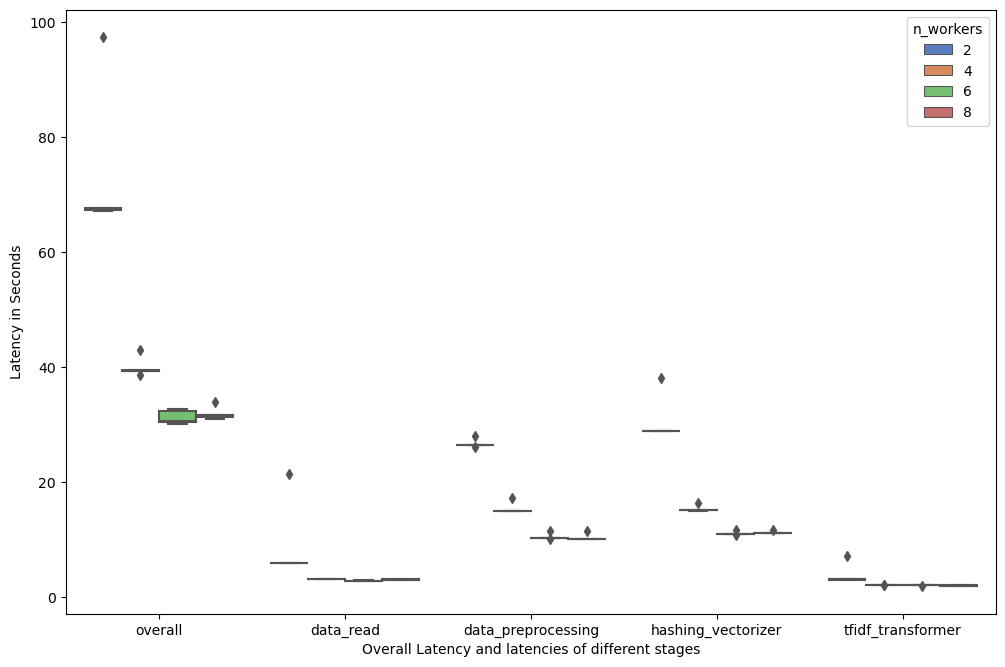

sample_run                    overall                  data_read  \
                mean       std count       mean        std count      mean   
n_workers                                                                    
2                  2  1.581139     5  73.407924  13.411537     5  8.932737   
4                  2  1.581139     5  39.890486   1.768134     5  3.072704   
6                  2  1.581139     5  31.170064   1.190775     5  2.817000   
8                  2  1.581139     5  31.856732   1.134447     5  2.977461   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
2          6.960586     5          26.642361  ...     5          30.666390   
4          0.023625     5          15.401698  ...     5          15.332111   
6          0.025480     5          10.416346  ...     5          11.033144   
8          0.059042     5          10.394802  ...     5          11.230452   

                          tfidf_transformer                     nrows       \
                std count              mean       std count      mean  std   
n_workers                                                                    
2          4.139648     5          3.828063  1.854937     5  20725971  0.0   
4          0.570090     5          2.023146  0.041773     5  20725971  0.0   
6          0.345978     5          1.986640  0.074961     5  20725971  0.0   
8          0.250232     5          1.936081  0.066259     5  20725971  0.0   

                 
          count  
n_workers        
2             5  
4             5  
6             5  
8             5  

[4 rows x 21 columns]

In [3]:
data_cuML, melt_data_cuML = visualize_data_cuML("./results/result_poc_nlp_dask_Books_persist.pkl")
groupy_cuML = data_cuML.groupby("n_workers").agg(['mean', 'std', 'count'])
groupy_cuML

# Visualize Data from Spark

## Data with persisting intermediate stages which will give us the latency of intermediate stages. 

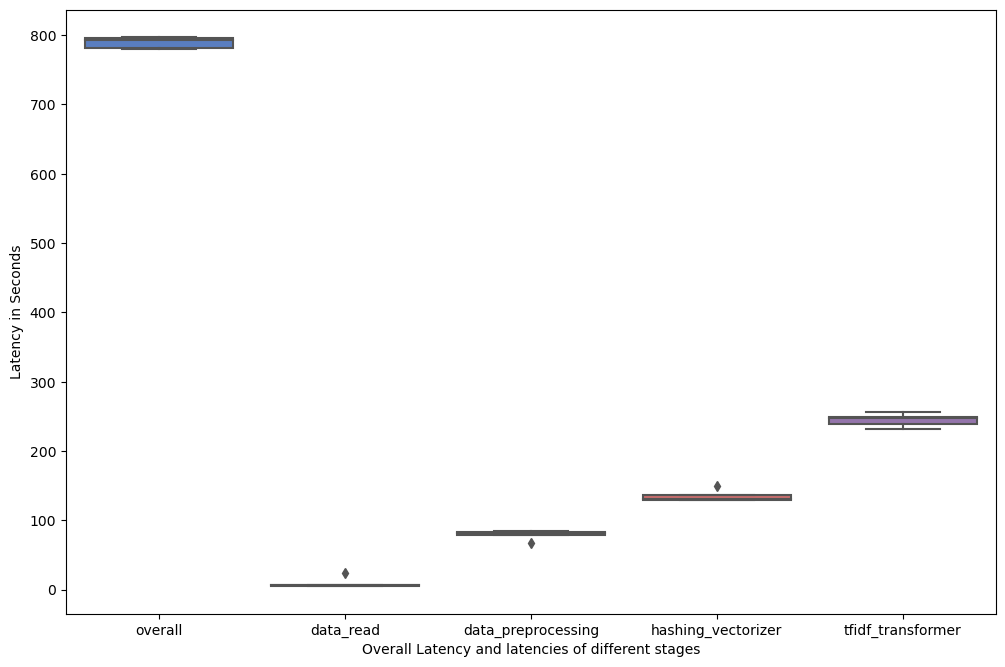

sample_run                     overall                data_read  \
                mean       std count        mean      std count      mean   
n_workers                                                                   
1                  2  1.581139     5  789.502847  8.37966     5  9.393355   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
1          7.770442     5          79.219912  ...     5          134.93359   

                          tfidf_transformer                    nrows       \
                std count              mean      std count      mean  std   
n_workers                                                                   
1          8.527056     5        244.402181  9.64639     5  20725971  0.0   

                 
          count  
n_workers        
1             5  

[1 rows x 21 columns]

In [4]:
data_spark_persist, melt_data_spark_persist = visualize_data_spark("./results/result_poc_nlp_spark_Books_persist.pkl")
groupy_spark_persist = data_spark_persist.groupby("n_workers").agg(['mean', 'std', 'count'])
groupy_spark_persist

In [5]:
data_spark_persist

,n_workers,sample_run,overall,data_read,data_preprocessing,hashing_vectorizer,tfidf_transformer,nrows
0,1,0,796.068379,23.227293,67.585144,130.730505,238.942433,20725971
1,1,1,779.390781,6.549512,82.040551,129.017402,249.036024,20725971
2,1,2,793.092165,6.748389,78.734102,149.428661,231.038699,20725971
3,1,3,781.651049,5.565269,84.349445,129.704747,246.931897,20725971
4,1,4,797.311864,4.876312,83.390320,135.786635,256.061851,20725971


## Data without persist, which will give us the end to end timing in real world scenarios.

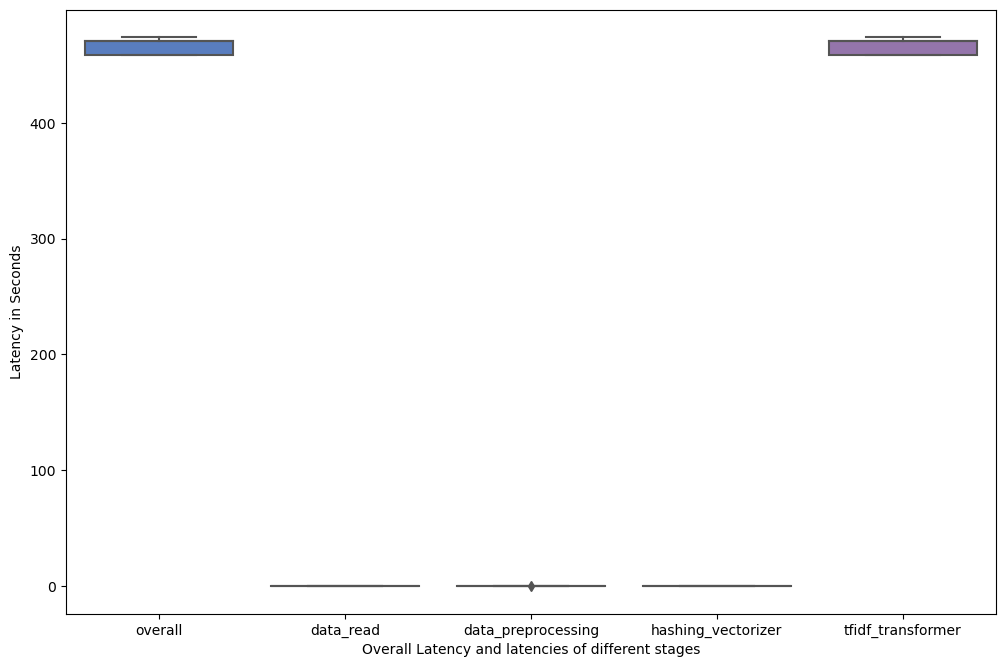

sample_run                     overall                 data_read  \
                mean       std count        mean       std count      mean   
n_workers                                                                    
1                  2  1.581139     5  466.508733  7.329802     5  0.056958   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
1          0.006633     5           0.037207  ...     5          -0.082034   

                          tfidf_transformer                     nrows       \
                std count              mean       std count      mean  std   
n_workers                                                                    
1          0.006568     5        466.333079  7.339739     5  20725971  0.0   

                 
          count  
n_workers        
1             5  

[1 rows x 21 columns]

In [6]:
data_spark_nonpersist, melt_data_spark_nonpersist = visualize_data_spark("./results/result_poc_nlp_spark_Books_nonpersist.pkl")
groupy_spark_nonpersist = data_spark_nonpersist.groupby("n_workers").agg(['mean', 'std', 'count'])
groupy_spark_nonpersist

# Baseline Scikit-Learn Performance

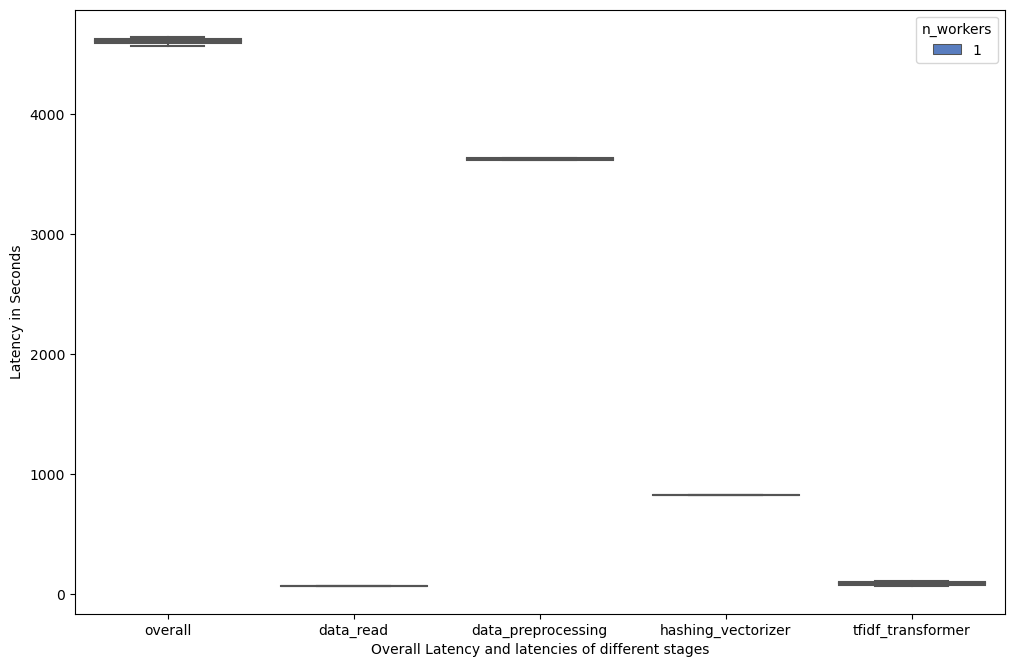

sample_run                      overall                   data_read  \
                mean       std count         mean        std count       mean   
n_workers                                                                       
1                0.5  0.707107     2  4603.981875  50.242347     2  66.078601   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
1          0.723926     2        3624.540174  ...     2         824.764701   

                          tfidf_transformer                      nrows       \
                std count              mean        std count      mean  std   
n_workers                                                                     
1          2.552245     2         88.385133  31.166265     2  20725971  0.0   

                 
          count  
n_workers        
1             2  

[1 rows x 21 columns]

In [7]:
data_sklearn, melt_data_sklearn = visualize_data_cuML("./results/result_poc_nlp_sklearn_Books.pkl") # we can use the cuML visualized function since all captured fields are same
groupy_sklearn = data_sklearn.groupby("n_workers").agg(['mean', 'std', 'count'])
groupy_sklearn

# Comparison of End to End times

## Calculations for the graph

In [8]:
melt_data_cuML["Experiment_Class"]="cuML + Dask"
melt_data_sklearn["Experiment_Class"] = "Scikit-Learn"
melt_data_spark_persist["Experiment_Class"]="Apache Spark"
melt_data_spark_nonpersist["Experiment_Class"] = "Apache Spark"
melt_data_spark_persist[melt_data_spark_persist.latency=="overall"] = melt_data_spark_nonpersist[melt_data_spark_nonpersist.latency=="overall"]
data = pd.concat([melt_data_sklearn, melt_data_spark_persist, melt_data_cuML[melt_data_cuML.n_workers==6]])

## Plot the latencies.

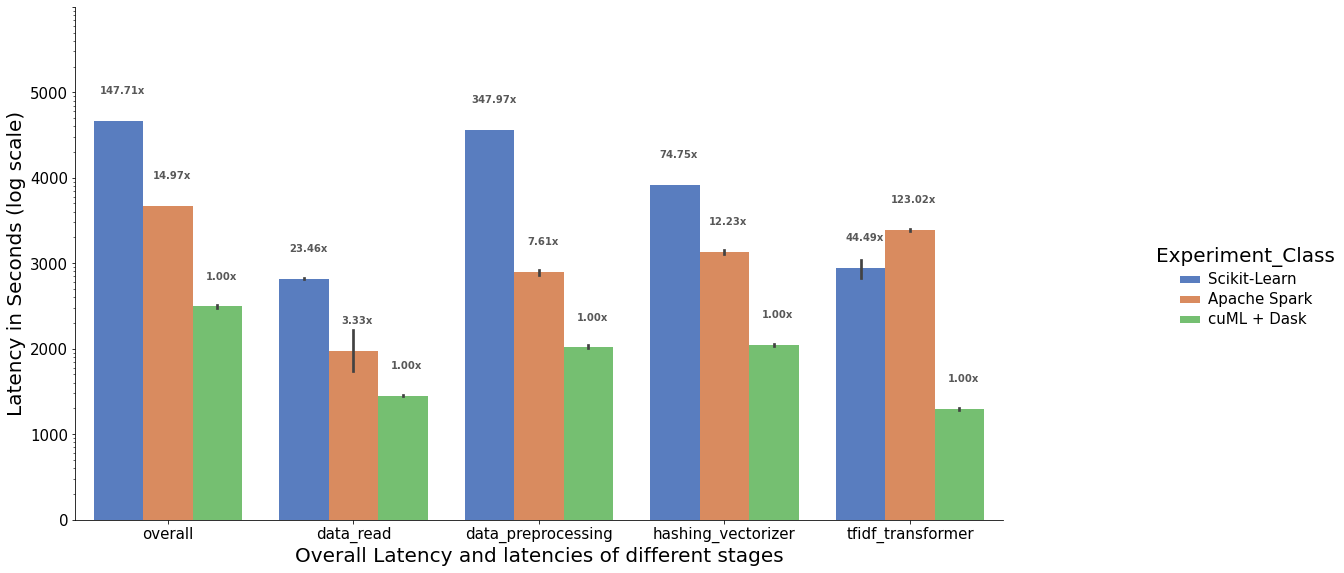

In [9]:
# with some help from https://stackoverflow.com/a/31754317
g = sns.catplot(x='latency', y='value', hue='Experiment_Class', data=data, kind='bar')
bar_order = product(["Scikit-Learn", "Apache Spark", "cuML + Dask"], ["overall", "data_read", "data_preprocessing", "hashing_vectorizer", "tfidf_transformer"], )
spots = zip(g.ax.patches, bar_order)
for spot in spots:
    corresponding_cuml_numbers = data[(data.Experiment_Class=="cuML + Dask") & (data.latency==spot[1][1])]
    mean_std = corresponding_cuml_numbers.value.mean()# + corresponding_cuml_numbers.value.std() 
    g.ax.annotate(f"{spot[0].get_height()/mean_std:.2f}x", (spot[0].get_x() + spot[0].get_width() / 2., spot[0].get_height()), ha='center', va='center', xytext=(4, 30), textcoords='offset points', fontsize=10, weight='bold', color="#585858")
g.fig.set_size_inches(20,8)
g.set(yscale="log")
g.set_xlabels("Overall Latency and latencies of different stages",fontsize=20)
g.set_ylabels("Latency in Seconds (log scale)",fontsize=20)
plt.setp(g._legend.get_title(), fontsize=20)
plt.setp(g._legend.texts, size=15)
g.set_xticklabels(size=15)
g.set_yticklabels(size=15)